In [2]:

import csv
import random
from functools import wraps
from time import time
from typing import Callable, Dict, List, Union, Any, Optional
import copy
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.evaluate import paired_ttest_5x2cv, bias_variance_decomp
from scipy import stats
from sklearn import (base, decomposition, dummy, ensemble, feature_selection,
                     linear_model, metrics, model_selection, neighbors,
                     pipeline, preprocessing, svm, tree)

In [3]:
# Created a config class to write global parameters.

In [4]:
class global_config:
    
    # File Path
    raw_data = "../data/raw/data.csv"
    processed_data = "Project2_Train.csv"
    test_data = "Project2_Test.csv"
    
    spot_checking_boxplot = "../data/images/spot_checking_boxplot.png"
    oof_confusion_matrix = "../data/images/oof_confusion_matrix.png"
    final_train_confusion_matrix = "../data/images/final_train_confusion_matrix.png"
    precision_recall_threshold_plot = "../data/images/precision_recall_threshold_plot.png"
    roc_plot = "../data/images/roc_plot.png"
    feature_importance = "../data/images/feature_importance.png"
    
    # Data Information
    target = ["Response"]
    unwanted_cols = ["id", "Unnamed: 32"]
    classification_type = "binary"

    # Plotting
    colors = ["#fe4a49", "#2ab7ca", "#fed766", "#59981A"]
    cmap_reversed = plt.cm.get_cmap('mako_r')
    
    # Seed Number
    seed = 1992

    # Cross Validation
    num_folds = 5
    cv_schema = "StratifiedKFold"
    split_size = {"train_size": 1, "test_size": 0}


def set_seeds(seed: int = 1234) -> None:
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)

In [5]:
# Read the csv file to a pandas dataframe.

In [6]:
config = global_config

# set seeding for reproducibility
_ = set_seeds(seed = config.seed)

# read data
df = pd.read_csv(config.processed_data)
df_test = pd.read_csv(config.test_data)

In [7]:
# Drop the redundant column id.

In [8]:
df.drop(columns=["id"], inplace=True)
df_test.drop(columns=["id"], inplace=True)

We first manually map the categorical features, Note the manual mapping we mapped letters to numbers, but for now, we will keep the 0, 1, 2 etc as strings, as function calls such as `pd.get_dummies` and `OneHotEncoder` work better when they see strings (which is a major signal for them to convert those columns).

In [9]:
categorical_feat = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Region_Code']
continuous_feat = ['Age', 'Annual_Premium', 'Vintage']
class_feat = ['Response']

# assert that these columns are of the correct dtype!
df = df.astype(
    {"Age": "int64", "Region_Code": "int64", "Annual_Premium": "int64", "Vintage": "int64", "Gender": "str", "Vehicle_Age":"str", "Vehicle_Damage":"str", "Response": "int64"}
)

df_test = df_test.astype(
    {"Age": "int64", "Region_Code": "int64", "Annual_Premium": "int64", "Vintage": "int64", "Gender": "str", "Vehicle_Age":"str", "Vehicle_Damage":"str", "Response": "int64"}
)


gender_map = {"Female": "0", "Male": "1"}
vehicle_age_map = {"< 1 Year": "0", "1-2 Year": "1", "> 2 Years":"2"}
vehicle_dmg_map = {"No":"0", "Yes":"1"}
region_code_map = {code: code for code in df.Region_Code.unique()}

cat_feature_map = {"Gender": gender_map, "Vehicle_Age": vehicle_age_map, "Vehicle_Damage": vehicle_dmg_map, "Region_Code":region_code_map}

for cat_col in categorical_feat:
    
    df[cat_col] = df[cat_col].map(cat_feature_map[cat_col])
    df_test[cat_col] = df_test[cat_col].map(cat_feature_map[cat_col])

In [10]:
X = df.copy()
y = X.pop("Response")

In [11]:
X_test = df_test.copy()
y_test = X_test.pop("Response")

In [12]:
# The below 3 code cells are just applying one hot encoding to gender and vehicle damage columns

In [13]:
import logging



log = logging.getLogger(__name__)
logging.basicConfig(level = logging.INFO)


class CategoricalDummyCoder(base.TransformerMixin):
    """https://stackoverflow.com/questions/39923927/pandas-sklearn-one-hot-encoding-dataframe-or-numpy
    Identifies categorical columns by dtype of object and dummy codes them. Optionally a pandas.DataFrame
    can be returned where categories are of pandas.Category dtype and not binarized for better coding strategies
    than dummy coding."""

    def __init__(self, only_categoricals=False, selected_columns=None, **get_dummies_kwargs):
        self.categorical_variables = []
        self.categories_per_column = {}
        self.only_categoricals = only_categoricals
        self.selected_columns = selected_columns
        self.get_dummies_kwargs = get_dummies_kwargs['get_dummies_kwargs']

    def fit(self, X, y=None):
        if self.selected_columns is None:
            logging.info("No selected columns by user, we will use all columns that is string")
            self.categorical_variables = list(X.select_dtypes(include=['object']).columns)
        else: 
            logging.info("Users have chosen selected columns to fit")
            self.categorical_variables = list(self.selected_columns)
            
        logging.debug(f'identified the following categorical variables: {self.categorical_variables}')

        for col in self.categorical_variables:
            self.categories_per_column[col] = X[col].astype('category').cat.categories
        logging.debug('fitted categories')

        return self

    def transform(self, X):
        for col in self.categorical_variables:
            logging.debug(f'transforming cat col: {col}')
            X[col] = pd.Categorical(X[col], categories=self.categories_per_column[col])
            if self.only_categoricals:
                X[col] = X[col].cat.codes
        if not self.only_categoricals:
            selected_cat_feat_df = pd.get_dummies(X[self.categorical_variables],  **self.get_dummies_kwargs)
            concat_df = pd.concat([X, selected_cat_feat_df], axis=1).drop(columns=self.categorical_variables, axis=1)
            return concat_df

        else:
            return X

In [14]:
one_hot_encoder = CategoricalDummyCoder(only_categoricals=False, selected_columns = ["Vehicle_Age", 'Vehicle_Damage', "Gender", "Region_Code"], get_dummies_kwargs = {"sparse":True, "drop_first":False})
X = one_hot_encoder.fit_transform(X)
X_test = one_hot_encoder.transform(X_test)

INFO:root:Users have chosen selected columns to fit


In [15]:
predictor_cols = X.columns.to_list()

In [16]:
# Split train - test
X_train, y_train =  X.copy(), y.copy() 

In [17]:
print(f"Y Train Distribution is : {y_train.value_counts(normalize=True).to_dict()}")
print(f"Y Test Distribution is : {y_test.value_counts(normalize=True).to_dict()}")

Y Train Distribution is : {0: 0.8674, 1: 0.1326}
Y Test Distribution is : {0: 0.8636, 1: 0.1364}


In [18]:
# The make fold function will further split the x training set into 5 different folds, and we stratified them accordingly.

In [19]:
def make_folds(
    df: pd.DataFrame,
    num_folds: int,
    cv_schema: str,
    seed: int,
    predictor_col: List,
    target_col: List,
) -> pd.DataFrame:
    """Split the given dataframe into training folds.

    Args:
        df (pd.DataFrame): [description]
        num_folds (int): [description]
        cv_schema (str): [description]
        seed (int): [description]

    Returns:
        pd.DataFrame: [description]
    """

    if cv_schema == "KFold":
        df_folds = df.copy()
        kf = model_selection.KFold(n_splits=num_folds, shuffle=True, random_state=seed)

        for fold, (train_idx, val_idx) in enumerate(
            kf.split(X=df_folds[predictor_col], y=df_folds[target_col])
        ):
            df_folds.loc[val_idx, "fold"] = int(fold + 1)

        df_folds["fold"] = df_folds["fold"].astype(int)

    elif cv_schema == "StratifiedKFold":
        df_folds = df.copy()
        skf = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

        for fold, (train_idx, val_idx) in enumerate(
            skf.split(X=df_folds[predictor_col], y=df_folds[target_col])
        ):
            df_folds.loc[val_idx, "fold"] = int(fold + 1)

        df_folds["fold"] = df_folds["fold"].astype(int)
        print(df_folds.groupby(["fold", target_col[0]]).size())

    return df_folds

In [20]:
X_y_train = pd.concat([X_train, y_train], axis = 1).reset_index(drop=True)
df_folds = make_folds(X_y_train, num_folds=config.num_folds, cv_schema=config.cv_schema, seed=config.seed, predictor_col= predictor_cols, target_col = config.target)

fold  Response
1     0           1735
      1            265
2     0           1735
      1            265
3     0           1735
      1            265
4     0           1735
      1            265
5     0           1734
      1            266
dtype: int64


In [21]:
# The make_pipeline function will first standardize our training data, then fit the model.

In [22]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
    """Make a Pipeline for Training.

    Args:
        model ([type]): [description]

    Returns:
        [type]: [description]
    """
    
    steps = list()
    # standardization
    steps.append(('standardize', preprocessing.StandardScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    _pipeline = pipeline.Pipeline(steps=steps)
    return _pipeline

In [23]:
# Now we define a list of classifier, which is a few models of our choice.

In [24]:
classifiers = [
    # linear model
    linear_model.LogisticRegression(random_state=config.seed, solver="liblinear"),
    #     # tree
    tree.DecisionTreeClassifier(random_state=config.seed),
    #     # ensemble
    ensemble.RandomForestClassifier(n_estimators=100, random_state=config.seed),
]

In [25]:
classifiers = [make_pipeline(model) for model in classifiers]

# Utils

## Results Class

This class is an abstract data structure that takes in default result names and store the results in columnwise format. This is abstract also because if you call `model_results` which is a dictionary, it returns `{'DummyClassifier': <__main__.Results at 0x1fd24436ca0>}`.

In [26]:
default_result_names = [
    "y_true",
    "y_pred",
    "y_prob",
    "brier_loss",
    "roc",
    "precision",
    "recall",
    "f1",
    "confusion_matrix",
]

default_logit_names = [
    "y_true",
    "y_pred",
    "y_prob"
]

default_score_names = [
    "brier_loss",
    "roc",
    "precision",
    "recall",
    "f1",
    "confusion_matrix"
]

class Results:
    """Stores results for model training in columnwise format."""
    
    _result_dict: Dict
     
    logit_names: List[str]
    score_names: List[str]
        
    def __init__(
        self,
        logit_names: List[str] = default_logit_names,
        score_names: List[str] = default_score_names,
        existing_dict: Optional[Dict] = None,
    ):
        """Construct a new results store."""       
        self.logit_names = logit_names
        self.score_names = score_names
        
        if existing_dict is not None:
            self._result_dict = copy.deepcopy(existing_dict)
            return
        
        dict_keys = ["identifier", *logit_names, *score_names]
        
        self._result_dict = {
            key: [] for key in dict_keys
        }
    
    def add(self, identifier: str, results: Dict, in_place=False):
        """Add a new results row."""        
        if not in_place:
            return Results(
                self.logit_names,
                self.score_names,
                self._result_dict
            ).add(identifier, results, in_place=True)
        
        self._result_dict["identifier"].append(identifier)
        
        for result_name in set([*results.keys(), *self.logit_names, *self.score_names]):
            result_value = results.get(result_name, np.nan)
            self._result_dict[result_name].append(result_value)
        
        return self
    
    def get_result(self, result_name: str) -> Dict[str, Any]:
        """Get a map of identifiers to result values for a result."""
        return {
            identifier: result_value for
            identifier, result_value in
            zip(self._result_dict["identifier"], self._result_dict[result_name])
        }
    
    def get_result_values(self, result_name: str) -> List[Any]:
        """Get a list of values for a result."""
        return self._result_dict[result_name]
    
    def to_dataframe(self) -> pd.DataFrame:
        """Get a Data Frame containing the results."""
        return pd.DataFrame.from_dict(self._result_dict)
    
    def to_dict(self) -> Dict:
        """Get a dictionary containing the results.
        
        Returns:
             Dict[str, List[Any]]: Dictionary of result columns 
        """
        return self._result_dict
        

## Metrics

In [27]:
def multiclass_label_binarize(y, classes, pos_label=1, neg_label=0):
    """Binarize labels in one-vs-all fashion.
    
    Args:
        y (np.ndarray) Sequence of integer labels to encode
        classes (array-like) Labels for each class
        pos_label (int) Value for positive labels
        neg_label (int) Value for negative labels
    Returns:
        np.ndarray of shape (n_samples, n_classes) Encoded dataset
    """
    columns = [
        np.where(y == label, pos_label, neg_label)
        for label in classes
    ]
    
    return np.column_stack(columns)


def multiclass_roc_auc_score(y_true, y_score, classes=None):
    """Compute ROC-AUC score for each class in a multiclass dataset.
    
    Args:
        y_true (np.ndarray of shape (n_samples, n_classes)) True labels
        y_score (np.ndarray of shape (n_samples, n_classes)) Target scores
        classes (array-like of shape (n_classes,)) List of dataset classes. If `None`,
            the lexicographical order of the labels in `y_true` is used.
    
    Returns:
        array-like: ROC-AUC score for each class, in the same order as `classes`
    """
    classes = (
        np.unique(y_true) if classes is None
        else classes
    )
    
    y_true_multiclass = multiclass_label_binarize(
        y_true,
        classes=classes
    )
    
    def oneclass_roc_auc_score(class_id):
        y_true_class = y_true_multiclass[:, class_id]
        y_score_class = y_score[:, class_id]
        
        fpr, tpr, _ = metrics.roc_curve(
            y_true=y_true_class,
            y_score=y_score_class,
            pos_label=1
        )
        
        return metrics.auc(
            fpr,
            tpr
        )
    
    return [
        oneclass_roc_auc_score(class_id)
        for class_id in range(len(classes))
    ]

In [28]:
def compute_metrics(logits: Dict[str, np.ndarray]) -> Dict[str, Any]:
    """Compute metrics from logits."""
    
    y_val, y_val_pred, y_val_prob = logits["y_true"], logits["y_pred"], logits["y_prob"]
    
    #val_score = metrics.roc_auc_score(
    #    y_true=y_val,
    #    y_score=y_val_prob
    #)
    
    val_score = multiclass_roc_auc_score(
        y_true=y_val,
        y_score=y_val_prob
    )
    
    precision, recall, fbeta_score, _ = metrics.precision_recall_fscore_support(
        y_true=y_val,
        y_pred = y_val_pred,
        labels=np.unique(y_val),
        average=None
    )

    brier_loss = (
        metrics.brier_score_loss(
            y_true=y_val,
            y_prob=y_val_prob[:, 1]
        )
        if config.classification_type == "binary"
        else np.nan
    )

    
    confusion_matrix = metrics.confusion_matrix(
        y_val,
        y_val_pred
    )
    
    return {
        "roc": val_score,
        "precision": precision,
        "recall": recall,
        "f1": fbeta_score,
        "brier_loss": brier_loss,
        "confusion_matrix": confusion_matrix
    }

In [29]:
def prepare_y(y):
    return (
        y.ravel()
        if config.classification_type == "binary"
        else y
    )

In [30]:
def mean_score(score_values) -> Union[float, np.ndarray]:
    """Compute the mean score."""
    
    score_values = np.array(score_values)
    
    shape = score_values.shape
    
    if len(shape) == 1:
        return score_values.mean()
    
    return score_values.mean(axis=0)

def mean_cv_results(model_results: Results) -> Dict:
    """Add mean cross-validation results.
    
    This method computes the mean value for all
    score types in the model_results, including
    for scores (e.g., confusion matrix) where
    the mean value may contain decimal places.
    """
    cv_logits = {
        y_result: np.concatenate(model_results.get_result_values(y_result))
        for y_result in
        model_results.logit_names
    }
    
    cv_scores = {
        score: mean_score(
            model_results.get_result_values(score)
        )
        for score in model_results.score_names
    }
    
    return {
        **cv_logits,
        **cv_scores,
    }

def oof_cv_results(model_results: Results) -> Dict:
    """Add OOF cross-validation results."""
    
    cv_logits = {
        y_result: np.concatenate(
            model_results.get_result_values(y_result)
        )
        for y_result in
        model_results.logit_names
    }
    
    cv_scores = compute_metrics(cv_logits)
    
    return {
        **cv_logits,
        **cv_scores,
    }

def add_cv_results(model_results: Results):
    """Add cross-validation results.
    
    This method returns a copy of the given model results
    with summary columns for mean and CV cross-validation.
    """
    mean_cv = mean_cv_results(model_results)
    oof_cv = oof_cv_results(model_results)
    
    return (
        model_results
        .add("mean_cv", mean_cv)
        .add("oof_cv", oof_cv)
    )

In [31]:
def train_on_fold(
    df_folds: pd.DataFrame,
    models: List[Callable],
    num_folds: int,
    predictor_col: List,
    target_col: List,
) -> Dict[str, List]:
    """Take in a dataframe with fold number as column, and a models which holds a list of callable models, we will loop through and return a dictionary of cv results.

    Args:
        df_folds (pd.DataFrame): [description]
        model (Callable): [description]
        num_folds (int): [description]
        predictor_col (List): [description]
        target_col (List): [description]


    Returns:
        Dict[str, List]: [description]
    """
  
    y_true = df_folds[target_col].values.flatten()

    # test_pred_arr: np.ndarray = np.zeros(len(X_test))

    model_dict = {}

    for model in models:
        model_results = Results()

        if isinstance(model, pipeline.Pipeline):
            model_name = model["model"].__class__.__name__
        else:
            model_name = model.__class__.__name__

        # out-of-fold validation predictions
        oof_pred_arr: np.ndarray = np.zeros(len(df_folds))
      
        for fold in range(1, num_folds + 1):

            train_df = df_folds[df_folds["fold"] != fold].reset_index(drop=True)
            val_df = df_folds[df_folds["fold"] == fold].reset_index(drop=True)
            val_idx = df_folds[df_folds["fold"] == fold].index.values
            X_train, y_train = train_df[predictor_col].values, prepare_y(train_df[target_col].values)
            X_val, y_val = val_df[predictor_col].values, prepare_y(val_df[target_col].values)
    
            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            y_val_prob = model.predict_proba(X_val)
            
            logits = {
                "y_true": y_val,
                "y_pred": y_val_pred,
                "y_prob": y_val_prob,
            }
            
            metrics = compute_metrics(logits)
            
            model_results.add(f"fold {fold}", {
                **logits,
                **metrics
            }, in_place=True)
            
           
        if model_name not in model_dict:
            model_dict[model_name] = model_results

    return model_dict

In [32]:
model_dict = train_on_fold(
    df_folds,
    models = classifiers,
    num_folds=5,
    predictor_col=predictor_cols,
    target_col = config.target
)

C:\Users\reighns\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\reighns\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\reighns\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [33]:
model_dict_with_summary = {
    model: add_cv_results(model_results)
    for model, model_results in model_dict.items()
}

In [34]:
results_df = pd.concat({
    name: results.to_dataframe().T
    for name, results
    in model_dict_with_summary.items()
}, axis=0)

results_df.columns = ['fold 1', 'fold 2', 'fold 3', 'fold 4', 'fold 5', 'mean_cv', 'oof_cv']
results_df

fold 1  \
LogisticRegression     identifier                                                   fold 1   
                       y_true            [0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_pred            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_prob            [[0.9913007976279888, 0.00869920237201111], [0...   
                       brier_loss                                                 0.095722   
                       roc                         [0.829466586917514, 0.8294665869175141]   
                       precision                                 [0.8674337168584292, 0.0]   
                       recall                                    [0.9994236311239193, 0.0]   
                       f1                                        [0.9287627209426889, 0.0]   
                       confusion_matrix                              [[1734, 1], [265, 0]]   
DecisionTreeClassifier identifier                                                   fold 1   
                       y_true            [0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_pred            [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_prob            [[1.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0...   
                       brier_loss                                                    0.194   
                       roc                        [0.6164210755260726, 0.6164210755260725]   
                       precision                  [0.8992294013040901, 0.3035143769968051]   
                       recall                     [0.8743515850144092, 0.3584905660377358]   
                       f1                           [0.886616014026885, 0.328719723183391]   
                       confusion_matrix                           [[1517, 218], [170, 95]]   
RandomForestClassifier identifier                                                   fold 1   
                       y_true            [0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_pred            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_prob            [[1.0, 0.0], [0.32, 0.68], [0.53, 0.47], [0.9,...   
                       brier_loss                                                 0.107495   
                       roc                        [0.7979500842803545, 0.7979500842803545]   
                       precision                  [0.8798511430090378, 0.3277310924369748]   
                       recall                     [0.9538904899135446, 0.1471698113207547]   
                       f1                                   [0.9153761061946902, 0.203125]   
                       confusion_matrix                            [[1655, 80], [226, 39]]   

                                                                                    fold 2  \
LogisticRegression     identifier                                                   fold 2   
                       y_true            [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, ...   
                       y_pred            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_prob            [[0.6945486216835197, 0.30545137831648034], [0...   
                       brier_loss                                                 0.097785   
                       roc                          [0.811457778261106, 0.811457778261106]   
                       precision                                             [0.8675, 0.0]   
                       recall                                                   [1.0, 0.0]   
                       f1                                          [0.92904953145917, 0.0]   
                       confusion_matrix                              [[1735, 0], [265, 0]]   
DecisionTreeClassifier identifier                                                   fold 2   
                       y_true            

In [35]:

def get_result(self, result_name: str) -> Dict[str, Any]:
    """Get a map of identifiers to result values for a result."""
    return {
        identifier: result_value for
        identifier, result_value in
        zip(self._result_dict["identifier"], self._result_dict[result_name])
    }

results_df = pd.concat({
    name: results.to_dataframe().T
    for name, results
    in model_dict_with_summary.items()
}, axis=0)

results_df.columns = ['fold 1', 'fold 2', 'fold 3', 'fold 4', 'fold 5', 'mean_cv', 'oof_cv']
results_df

fold 1  \
LogisticRegression     identifier                                                   fold 1   
                       y_true            [0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_pred            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_prob            [[0.9913007976279888, 0.00869920237201111], [0...   
                       brier_loss                                                 0.095722   
                       roc                         [0.829466586917514, 0.8294665869175141]   
                       precision                                 [0.8674337168584292, 0.0]   
                       recall                                    [0.9994236311239193, 0.0]   
                       f1                                        [0.9287627209426889, 0.0]   
                       confusion_matrix                              [[1734, 1], [265, 0]]   
DecisionTreeClassifier identifier                                                   fold 1   
                       y_true            [0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_pred            [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_prob            [[1.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0...   
                       brier_loss                                                    0.194   
                       roc                        [0.6164210755260726, 0.6164210755260725]   
                       precision                  [0.8992294013040901, 0.3035143769968051]   
                       recall                     [0.8743515850144092, 0.3584905660377358]   
                       f1                           [0.886616014026885, 0.328719723183391]   
                       confusion_matrix                           [[1517, 218], [170, 95]]   
RandomForestClassifier identifier                                                   fold 1   
                       y_true            [0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_pred            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_prob            [[1.0, 0.0], [0.32, 0.68], [0.53, 0.47], [0.9,...   
                       brier_loss                                                 0.107495   
                       roc                        [0.7979500842803545, 0.7979500842803545]   
                       precision                  [0.8798511430090378, 0.3277310924369748]   
                       recall                     [0.9538904899135446, 0.1471698113207547]   
                       f1                                   [0.9153761061946902, 0.203125]   
                       confusion_matrix                            [[1655, 80], [226, 39]]   

                                                                                    fold 2  \
LogisticRegression     identifier                                                   fold 2   
                       y_true            [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, ...   
                       y_pred            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       y_prob            [[0.6945486216835197, 0.30545137831648034], [0...   
                       brier_loss                                                 0.097785   
                       roc                          [0.811457778261106, 0.811457778261106]   
                       precision                                             [0.8675, 0.0]   
                       recall                                                   [1.0, 0.0]   
                       f1                                          [0.92904953145917, 0.0]   
                       confusion_matrix                              [[1735, 0], [265, 0]]   
DecisionTreeClassifier identifier                                                   fold 2   
                       y_true            

,model,fold,roc
6,DecisionTreeClassifier,fold 1,0.616421
7,DecisionTreeClassifier,fold 2,0.619879
8,DecisionTreeClassifier,fold 3,0.565608
9,DecisionTreeClassifier,fold 4,0.593856
10,DecisionTreeClassifier,fold 5,0.609046
11,DecisionTreeClassifier,SE,0.009906
12,RandomForestClassifier,fold 1,0.797950
13,RandomForestClassifier,fold 2,0.795608
14,RandomForestClassifier,fold 3,0.798346
15,RandomForestClassifier,fold 4,0.814966


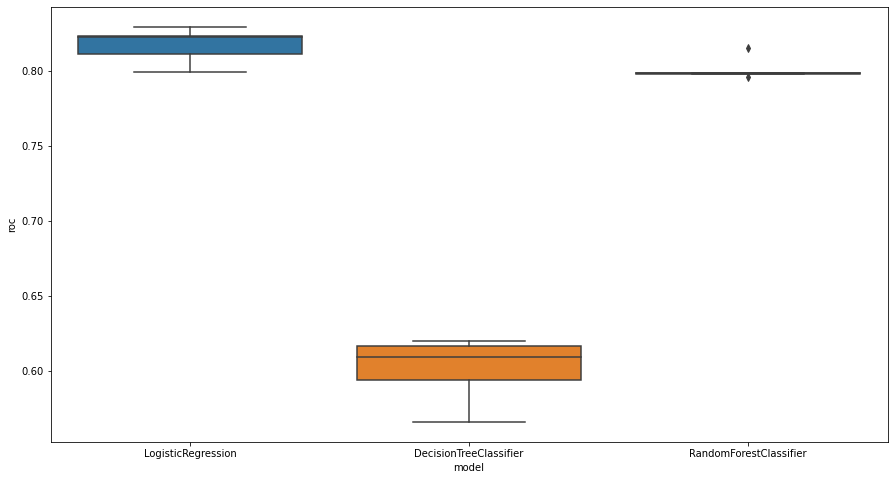

In [36]:
def summarize_metrics(model_dict: Dict, metric_name:str="roc", pos_label:int=1):
    """
    Summarize metrics of each fold with its standard error.
    We also plot a boxplot to show the results.
    """
    
    
    results = []
    
    
    for model_name, model_results in model_dict.items():
        result_dict = model_results.get_result(result_name=metric_name)
        
        tmp_score = []
        for fold, metric in result_dict.items():
            pos_class_score = metric[pos_label]
            results.append((model_name, fold, pos_class_score))
            tmp_score.append(pos_class_score)
        
        # append the Standard Error of K folds
        results.append((model_name, "SE", np.std(tmp_score, ddof=1) / len(tmp_score) ** 0.5))
    
    
    summary_df = pd.DataFrame(results, columns=["model", "fold", metric_name])
    
    fig, ax = plt.subplots(figsize=(15, 8))
    _ = sns.boxplot(x="model", y=metric_name, data=summary_df[(summary_df['model'] != 'DummyClassifier') & (summary_df['fold'] != 'SE')], ax=ax)
    
   # fig.savefig(config.spot_checking_boxplot, format='png', dpi=300)
    
    return summary_df

summary_df = summarize_metrics(model_dict = model_dict, metric_name="roc")
display(summary_df.tail(12))

In [37]:
model_names = [model for model in model_dict.keys()]

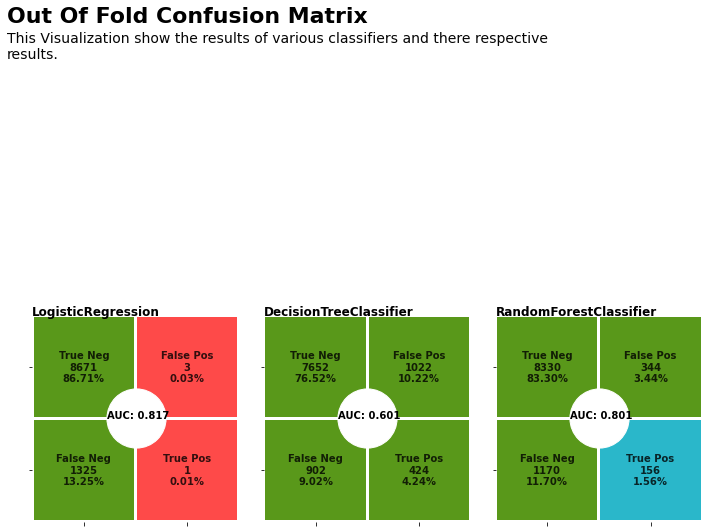

In [38]:

fig, ax = plt.subplots(1, 3, figsize=(10, 10))

for axes, algo in zip(ax.ravel(), model_names):

    cf_mat = results_df.oof_cv[algo].confusion_matrix
    #### scores
    positive_class_auroc = results_df.oof_cv[algo].roc[1]
    

    #### annotations
    labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
    counts = ["{0:0.0f}".format(value) for value in cf_mat.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cf_mat.flatten() / np.sum(cf_mat)]

    #### final annotations
    label = (
        np.array([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, counts, percentages)])
    ).reshape(2, 2)

    # heatmap
    sns.heatmap(
        data=cf_mat,
        vmin=0,
        vmax=330,
        cmap=["#fe4a49", "#2ab7ca", "#fed766", "#59981A"],
        linewidth=2,
        linecolor="white",
        square=True,
        ax=axes,
        annot=label,
        fmt="",
        cbar=False,
        annot_kws={"size": 10, "color": "black", "weight": "bold", "alpha": 0.8},
        alpha=1,
    )

    axes.text(0, -0, "{}".format(algo), {"size": 12, "color": "black", "weight": "bold"})

    axes.scatter(1, 1, s=3500, c="white")
    axes.text(
        0.72,
        1.0,
        "AUC: {}".format(np.round(positive_class_auroc, 3)), 
        {"size": 10, "color": "black", "weight": "bold"},
    )

    ## ticks and labels
    axes.set_xticklabels("")
    axes.set_yticklabels("")


## titles and text
fig.text(0, 1.05, "Out Of Fold Confusion Matrix", {"size": 22, "weight": "bold"}, alpha=1)
fig.text(
    0,
    1,
    """This Visualization show the results of various classifiers and there respective
results.""",
    {"size": 14, "weight": "normal"},
    alpha=0.98,
)


fig.tight_layout(pad=2.5, w_pad=2.5, h_pad=2.5)
# fig.savefig(config.oof_confusion_matrix, format='png', dpi=300)

# Hyperparameter

In [39]:
# create a feature preparation pipeline for a model
def make_finetuning_pipeline(model):
    """Make a Pipeline for Training.

    Args:
        model ([type]): [description]

    Returns:
        [type]: [description]
    """
    
    steps = list()
    # standardization
    steps.append(('standardize', preprocessing.StandardScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    _pipeline = pipeline.Pipeline(steps=steps)
    return _pipeline

In [40]:
pipeline_logistic = make_finetuning_pipeline(linear_model.LogisticRegression(random_state=config.seed, solver='liblinear'))
pipeline_decision_tree = make_finetuning_pipeline(tree.DecisionTreeClassifier(random_state=config.seed))

debug = True
if debug:
    pipeline_random_forest = make_finetuning_pipeline(ensemble.RandomForestClassifier(n_estimators=1, random_state=config.seed))
else:
    pipeline_random_forest = make_finetuning_pipeline(ensemble.RandomForestClassifier(n_estimators=100, random_state=config.seed))

In [41]:
logistic_param_grid = dict(model__C=np.logspace(-4, 4, 10), model__penalty=["l1", "l2"])


# https://stackoverflow.com/questions/46480457/difference-between-min-samples-split-and-min-samples-leaf-in-sklearn-decisiontre
# min samples in a leaf should necessarily be odd to avoid tie in majority voting.
# https://stackoverflow.com/questions/43963365/how-to-tune-sklearns-randomforest-max-depth-vs-min-samples-leaf

dt_param_grid = dict(
    model__criterion=["gini", "entropy"],
    model__max_depth=[i for i in range(1, 15, 1)],
    model__min_samples_leaf=[3, 5, 7, 9, 11, 13],
)


rf_param_grid = dict(
    model__criterion=["gini", "entropy"],
    model__max_depth=[i for i in range(1, 15, 1)],
    model__min_samples_leaf=[3, 5, 7, 9, 11, 13],
)


In [42]:
grid_logistic = model_selection.GridSearchCV(pipeline_logistic, param_grid=logistic_param_grid, cv=5, refit=True, verbose=0, scoring = "roc_auc")
_ = grid_logistic.fit(X_train.values, y_train.values)

grid_dt = model_selection.GridSearchCV(pipeline_decision_tree, param_grid=dt_param_grid, cv=5, refit=True, verbose=0, scoring = "roc_auc")
_ = grid_dt.fit(X_train.values, y_train.values)

grid_rf = model_selection.GridSearchCV(pipeline_random_forest, param_grid=rf_param_grid, cv=5, refit=True, verbose=0, scoring = "roc_auc")
_ = grid_rf.fit(X_train.values, y_train.values)

In [43]:
cv_results = pd.DataFrame(grid_logistic.cv_results_).sort_values(
    "mean_test_score", ascending=False)


# get the parameter names
column_results = [f"param_{name}" for name in logistic_param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,C,penalty,mean_test_score,std_test_score,rank_test_score
8,0.359381,l1,0.817990,0.007830,1
10,2.782559,l1,0.817900,0.007826,2
12,21.544347,l1,0.817868,0.007823,3
9,0.359381,l2,0.817868,0.007848,4
11,2.782559,l2,0.817867,0.007828,5
14,166.810054,l1,0.817860,0.007818,6
17,1291.549665,l2,0.817859,0.007815,7
19,10000.0,l2,0.817859,0.007815,7
15,166.810054,l2,0.817858,0.007815,9
16,1291.549665,l1,0.817858,0.007817,10


In [44]:
cv_results = pd.DataFrame(grid_dt.cv_results_).sort_values(
    "mean_test_score", ascending=False)


# get the parameter names
column_results = [f"param_{name}" for name in dt_param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,criterion,max_depth,min_samples_leaf,mean_test_score,std_test_score,rank_test_score
21,gini,4,9,0.818482,0.005350,1
22,gini,4,11,0.818390,0.005198,2
23,gini,4,13,0.818338,0.005103,3
20,gini,4,7,0.818105,0.005469,4
19,gini,4,5,0.817740,0.005811,5
...,...,...,...,...,...,...
163,entropy,14,5,0.754388,0.017172,164
79,gini,14,5,0.750641,0.016970,165
162,entropy,14,3,0.748512,0.018148,166
72,gini,13,3,0.746442,0.020769,167


In [45]:
cv_results = pd.DataFrame(grid_rf.cv_results_).sort_values(
    "mean_test_score", ascending=False)


# get the parameter names
column_results = [f"param_{name}" for name in rf_param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,criterion,max_depth,min_samples_leaf,mean_test_score,std_test_score,rank_test_score
19,gini,4,5,0.809695,0.008776,1
106,entropy,4,11,0.809282,0.006761,2
107,entropy,4,13,0.809282,0.006761,2
23,gini,4,13,0.808963,0.009294,4
22,gini,4,11,0.808963,0.009294,4
...,...,...,...,...,...,...
144,entropy,11,3,0.755646,0.011515,164
156,entropy,13,3,0.743200,0.030837,165
78,gini,14,3,0.742452,0.013079,166
162,entropy,14,3,0.740631,0.022496,167


# Export Tree Viz

In [46]:
import graphviz

In [47]:
dot_data = tree.export_graphviz(grid_dt.best_estimator_['model'], out_file=None, 
            filled=True, rounded=True, feature_names=predictor_cols, class_names=['0','1'], special_characters=True)

graph = graphviz.Source(dot_data)  

In [48]:
# graph.format = "png"
# graph.render("health")

In [51]:
fig = plt.figure(figsize=(50, 35), dpi= 300)
_ = tree.plot_tree(grid_dt.best_estimator_['model'],  filled=True, rounded=True, feature_names=predictor_cols, class_names=['0','1'])
fig.savefig("dt_plot.png", dpi=300)
# plt.show()

# Feature Importance

In [44]:
def get_feature_importance(estimator: Callable,
                            predictor_cols:List[str],
                            has_feature_selection:bool=False):
    """
    If there is custom preprocessing feature selection step, like VIF, then we need to use different method to extract the features.
    
    predictor_cols: must be in sequence, how you pass in to train should preserve sequence.
    """
    
    linear_models = ['LinearRegression', 'LogisticRegression']
    tree_models = ['DecisionTreeClassifier', 'RandomForestClassifier']
    estimator_name = estimator.__class__.__name__
    
    if has_feature_selection:
        pass
    
    else:
        if estimator_name in linear_models:
            coefficient = pd.DataFrame(estimator.coef_.flatten(), columns = ['Coefficients'], index=predictor_cols)
            coefficient.sort_values(by='Coefficients').plot(kind='barh', figsize=(9,7))
            plt.title(f"{estimator_name}")
            plt.axvline(x=0, color='.5')
            plt.subplots_adjust(left=.3)
        
        elif estimator_name in tree_models:
            coefficient = pd.DataFrame(estimator.feature_importances_, columns = ['Coefficients'], index=predictor_cols)
            coefficient.sort_values(by='Coefficients').plot(kind='barh', figsize=(9,7))
            plt.title(f"{estimator_name}")
            plt.axvline(x=0, color='.5')
            plt.subplots_adjust(left=.3)
            
    return coefficient

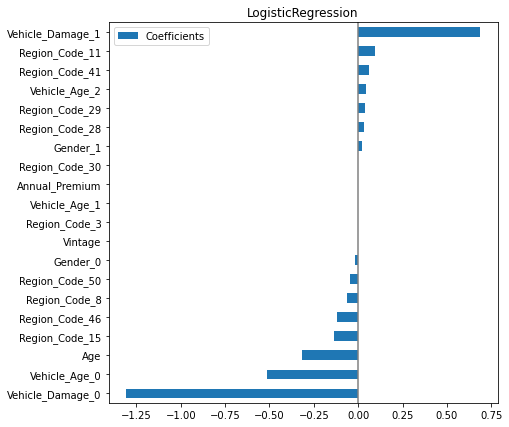

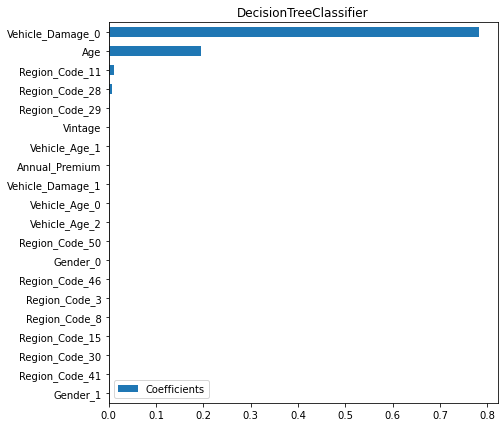

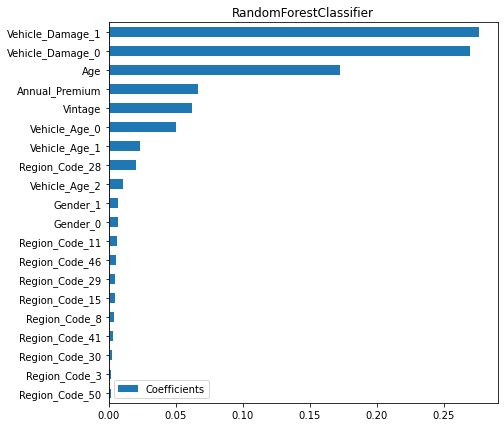

In [45]:
predictor_cols = X_train.columns

coef_logistic = get_feature_importance(estimator=grid_logistic.best_estimator_['model'],
                           predictor_cols=predictor_cols)

coef_dt = get_feature_importance(estimator=grid_dt.best_estimator_['model'],
                           predictor_cols=predictor_cols)

coef_rf = get_feature_importance(estimator=grid_rf.best_estimator_['model'],
                           predictor_cols=predictor_cols)

# Evaluate Performance on Test Set

In [55]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    and courtesy of https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    # plt.savefig(config.roc_plot, format="png", dpi=300)

In [56]:
y_test_gt = np.asarray(y_test)


y_test_logistic_prob = grid_logistic.predict_proba(X_test.values)[:, 1]

roc_auc_logistic = metrics.roc_auc_score(y_test_gt, y_test_logistic_prob)
print(roc_auc_logistic)

0.81786215276976


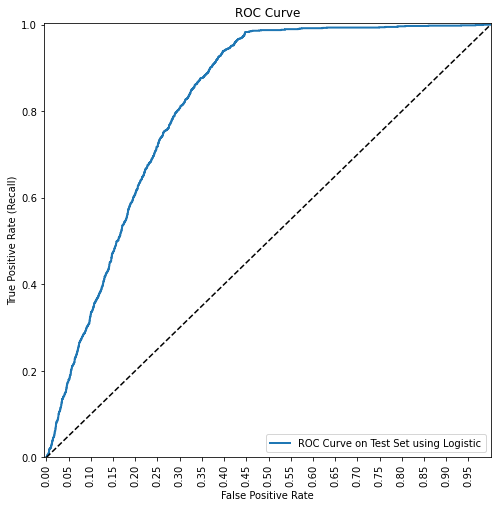

In [58]:
# generate the precision recall curve

fpr, tpr, roc_thresholds = metrics.roc_curve(y_test_gt,y_test_logistic_prob,pos_label=1)

plot_roc_curve(fpr, tpr, label="ROC Curve on Test Set using Logistic")

# Benefit Structure


In [46]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    and courtesy of https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    """
    return [1 if y >= t else 0 for y in y_scores]

In [47]:
def return_benefit_structure(thresholds: List[float],
                             y_true: np.ndarray,
                             y_prob: np.ndarray
                            ):


    columns = ["threshold", "tp", "fn", "fp", "tn", "benefit_cost_old", "benefit_cost_new"]
    benefit_cost_list = []

    for t in threshold_list:
        y_pred_adj = adjusted_classes(y_prob, t=t)
        cm = metrics.confusion_matrix(y_true=y_true, y_pred = y_pred_adj)
        tn, fp, fn, tp = metrics.confusion_matrix(y_true=y_true, y_pred = y_pred_adj).ravel()

        # this one check if it is correct formula
        benefit_cost_old = tp*10 - fn*10 - fp*2 - (tp+fp)*1
        benefit_cost_new = tp*100 - fn*100 - fp*2 - (tp+fp)*1

        benefit_cost_list.append([t, tn, fn, fp, tn, benefit_cost_old, benefit_cost_new])
    
    
    benefit_df = pd.DataFrame(benefit_cost_list,
                   columns=columns)
    
    return benefit_df

In [48]:
threshold_list : List[float] = [0.01, 0.1, 0.2, 0.5]
y_test_gt = np.asarray(y_test)


y_test_logistic_prob = grid_logistic.predict_proba(X_test.values)[:, 1]
y_test_dt_prob = grid_dt.predict_proba(X_test.values)[:, 1]
y_test_rf_prob = grid_rf.predict_proba(X_test.values)[:, 1]

In [49]:
return_benefit_structure(thresholds=threshold_list, y_true=y_test_gt, y_prob=y_test_logistic_prob)

,threshold,tp,fn,fp,tn,benefit_cost_old,benefit_cost_new
0,0.01,4622,19,4014,4622,-127,119213
1,0.10,4780,29,3856,4780,157,117697
2,0.20,5906,233,2730,5906,-341,80479
3,0.50,8636,1364,0,8636,-13640,-136400


In [50]:
return_benefit_structure(thresholds=threshold_list, y_true=y_test_gt, y_prob=y_test_dt_prob)

,threshold,tp,fn,fp,tn,benefit_cost_old,benefit_cost_new
0,0.01,4412,16,4224,4412,-700,119180
1,0.10,5092,68,3544,5092,352,110872
2,0.20,6111,245,2525,6111,46,78706
3,0.50,8636,1364,0,8636,-13640,-136400


In [51]:
return_benefit_structure(thresholds=threshold_list, y_true=y_test_gt, y_prob=y_test_rf_prob)

,threshold,tp,fn,fp,tn,benefit_cost_old,benefit_cost_new
0,0.01,3821,10,4815,3821,-2359,118601
1,0.10,5017,50,3619,5017,469,114229
2,0.20,5868,187,2768,5868,419,89519
3,0.50,8636,1364,0,8636,-13640,-136400


# Bias-Variance Tradeoff

In [ ]:
# avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
#         grid.best_estimator_['model'], X_train.values, y_train.values, X_test.values, y_test.values, 
#         loss='0-1_loss',
#         random_seed=123)

# print('Average expected loss: %.3f' % avg_expected_loss)
# print('Average bias: %.3f' % avg_bias)
# print('Average variance: %.3f' % avg_var)